# Anomally Generative Adversarian Network (AnoGAN)

In [2]:
from __future__ import print_function

import matplotlib
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import argparse
import anogan

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
### 0. prepare data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_test_original = X_test.copy()

X_train = X_train[y_train==1]
X_test = X_test[y_test==1]
print ('train shape:', X_train.shape)

11493376/11490434 [==============================] - 1s 0us/step
train shape: (6742, 28, 28, 1)


In [5]:
Model_d, Model_g = anogan.train(64, X_train)

Epoch is 0
104/105 [============================>.] - ETA: 1s - g: 0.3078 - d: 0.2328
Epoch is 1
104/105 [============================>.] - ETA: 1s - g: 0.2932 - d: 0.2975
Epoch is 2
104/105 [============================>.] - ETA: 1s - g: 0.3664 - d: 0.3937
Epoch is 3
104/105 [============================>.] - ETA: 1s - g: 0.7364 - d: 0.4981
Epoch is 4
104/105 [============================>.] - ETA: 1s - g: 0.8974 - d: 0.5001
Epoch is 5
104/105 [============================>.] - ETA: 1s - g: 0.7518 - d: 0.4750
Epoch is 6
104/105 [============================>.] - ETA: 1s - g: 3.8974e-05 - d: 0.4999
Epoch is 7
104/105 [============================>.] - ETA: 1s - g: 0.2773 - d: 0.3100
Epoch is 8
104/105 [============================>.] - ETA: 1s - g: 1.0000 - d: 0.5000
Epoch is 9
104/105 [============================>.] - ETA: 1s - g: 0.8257 - d: 0.4918


In [6]:
### 2. test generator
generated_img = anogan.generate(25)
img = anogan.combine_images(generated_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)

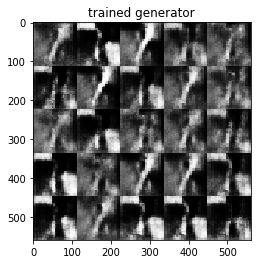

In [7]:
### plt view
plt.figure(num=0, figsize=(4, 4))
plt.title('trained generator')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [8]:
### 3. other class anomaly detection

def anomaly_detection(test_img, g=None, d=None):
    model = anogan.anomaly_detector(g=g, d=d)
    ano_score, similar_img = anogan.compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(28,28,1) - similar_img.reshape(28,28,1)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show

In [12]:
def anomaly_evaluation(test_img, label_idx, img_idx):
    start = cv2.getTickCount()
    score, qurey, pred, diff = anomaly_detection(test_img)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    print ('%d label, %d : done'%(label_idx, img_idx), '%.2f'%score, '%.2fms'%time)
    
    ## matplot view
    plt.figure(1, figsize=(3, 3))
    plt.title('query image')
    plt.imshow(qurey.reshape(28,28), cmap=plt.cm.gray)

    print("anomaly score : ", score)
    plt.figure(2, figsize=(3, 3))
    plt.title('generated similar image')
    plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

    plt.figure(3, figsize=(3, 3))
    plt.title('anomaly detection')
    plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
    plt.show()

1 label, 30 : done 359.80 6639.02ms
anomaly score :  359.79852294921875


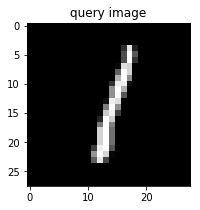

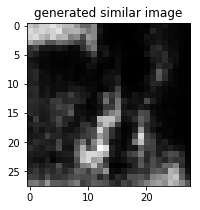

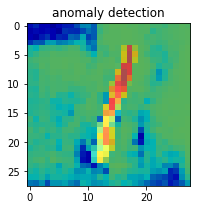

0 label, 30 : done 464.71 6987.31ms
anomaly score :  464.7147521972656


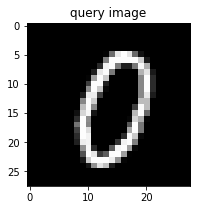

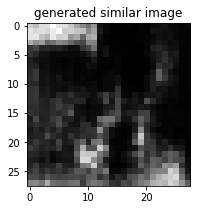

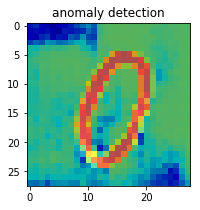

In [13]:
### compute anomaly score - sample from test set
test_img = X_test_original[y_test==1][30]
anomaly_evaluation(test_img, 1, 30)

### compute anomaly score - sample from strange image
test_img = X_test_original[y_test==0][30]
anomaly_evaluation(test_img, 0, 30)

random noise image
100/100 [==============================] - 0s 530us/step


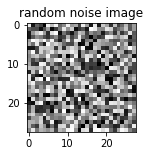

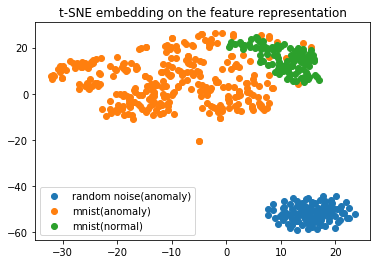

In [14]:
### 4. tsne feature view

### t-SNE embedding 
### generating anomaly image for test (radom noise image)

from sklearn.manifold import TSNE

random_image = np.random.uniform(0, 1, (100, 28, 28, 1))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)

# intermidieate output of discriminator
model = anogan.feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test_original[y_test != 1][:300], verbose=1)
feature_map_of_minist_1 = model.predict(X_test[:100], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist, feature_map_of_minist_1))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.figure(5)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400,0], X_embedded[100:400,1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:,0], X_embedded[400:,1], label='mnist(normal)')
plt.legend()
plt.show()